In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

In [11]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [2]:
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2'], axis=1)
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

In [5]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

In [7]:
len(data.columns)

26

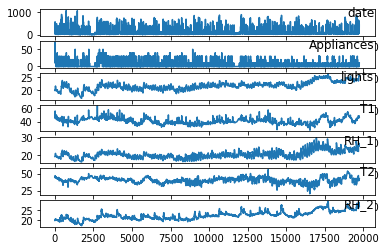

In [10]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
pyplot.close('all')

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.037383


In [14]:
len(reframed.values)

19734

In [15]:
values = reframed.values
train_size=int(len(values) *0.75)
test_size = int(len(values)) - train_size
print(test_size)

4934


In [30]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 1, 26) (14800,) (4934, 1, 26) (4934,)


In [26]:
train_y

array([0.04672897, 0.03738318, 0.03738318, ..., 0.27102804, 0.27102804,
       0.25233645])

In [18]:
# design network
neurons = 50
batch_size = 1
epochs = 100
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [19]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                15400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 15,451
Trainable params: 15,451
Non-trainable params: 0
_________________________________________________________________


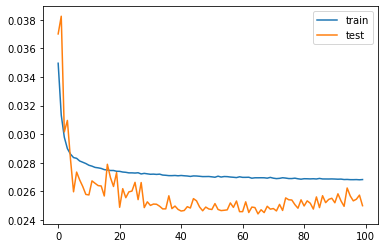

In [20]:
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.clf()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('loss.png')
pyplot.close('all')

In [37]:
yhat

array([[0.18252833],
       [0.18411028],
       [0.20888431],
       ...,
       [0.06718878],
       [0.15561292],
       [0.20900823]], dtype=float32)

In [31]:
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 63.143
Test MAPE: 27.119
Test SMAPE: 11.309


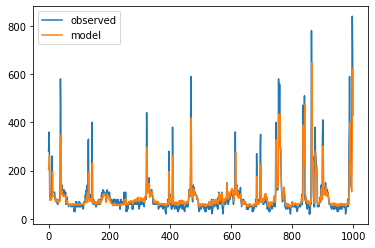

In [35]:
# plot baseline and predictions
pyplot.clf()
pyplot.plot(inv_y[0:1000], label="observed")
pyplot.plot(inv_yhat[0:1000], label="model")
pyplot.legend()
pyplot.show()
#pyplot.savefig('test_and_train.png')
pyplot.close('all')